In [5]:
import glob
import random

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

DATA_DIR = '/fast_storage/intern/data/instruction_tuning/brats_segmentation_mat_2/test'
# DATA_DIR = './brats_segmentation_mat'
# DATA_DIR = './brats_crossmodal_mat'
SEED = 42


In [6]:
random.seed(SEED)
files = sorted(glob.glob(f'{DATA_DIR}/*.mat'))
if not files:
    raise FileNotFoundError(f'No .mat files found under {DATA_DIR}')
print(f'Found {len(files)} .mat files')
sample_path = random.choice(files)
print('Sample:', sample_path)

print(f"keys: {list(loadmat(sample_path).keys())}")

Found 4032 .mat files
Sample: /fast_storage/intern/data/instruction_tuning/brats_segmentation_mat_2/test/brats_01622_t2_s051_n01207.mat
keys: ['__header__', '__version__', '__globals__', 'image', 'label', 'instruction', 'text']


In [7]:
def load_data(sample_path):
    data = loadmat(sample_path)
    image = data['image']
    label = data['label']
    text = data['text']
    instruction = data['instruction']

    # Handle MATLAB string formats
    if isinstance(text, np.ndarray):
        text = text.squeeze()
        if text.dtype.kind in {'U', 'S'}:
            text = str(text)
        elif text.dtype == object:
            text = str(text.tolist())

    print('Instruction:', instruction)
    print('Metadata:', text)
    print('Image shape:', image.shape, 'Label shape:', label.shape)
    return image, label


In [8]:
def visualize_seg(image, label):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(label, cmap='viridis')
    plt.title('Label')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image, cmap='gray')
    plt.imshow(label, cmap='viridis', alpha=0.4)
    plt.title('Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_crossmodal(image, label):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray')
    plt.title('Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Instruction: [[array(['Extract the tumor region from this T2 MRI slice.'], dtype='<U48')]]
Metadata: ["<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'\nsizeof_hdr      : 348\ndata_type       : np.bytes_(b'')\ndb_name         : np.bytes_(b'')\nextents         : 0\nsession_error   : 0\nregular         : np.bytes_(b'r')\ndim_info        : 0\ndim             : [  3 240 240 155   1   1   1   1]\nintent_p1       : 0.0\nintent_p2       : 0.0\nintent_p3       : 0.0\nintent_code     : none\ndatatype        : float32\nbitpix          : 32\nslice_start     : 0\npixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]\nvox_offset      : 0.0\nscl_slope       : nan\nscl_inter       : nan\nslice_end       : 0\nslice_code      : unknown\nxyzt_units      : 2\ncal_max         : 0.0\ncal_min         : 0.0\nslice_duration  : 0.0\ntoffset         : 0.0\nglmax           : 0\nglmin           : 0\ndescrip         : np.bytes_(b'')\naux_file        : np.bytes_(b'')\nqform_code      : scanner\nsform_code      : unkn

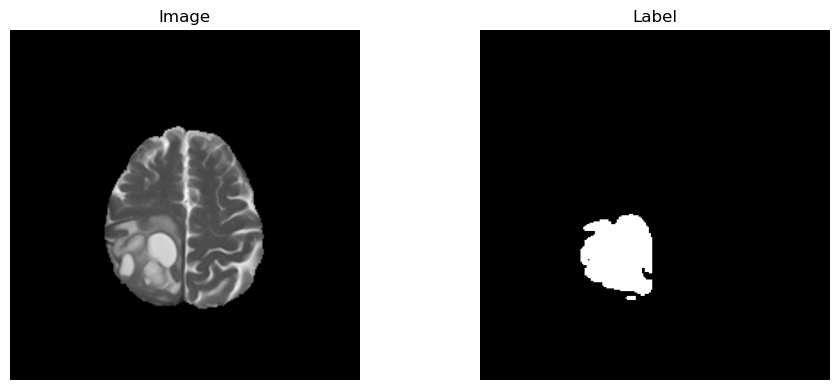

In [12]:
sample_path = random.choice(files)
image, label = load_data(sample_path)
# visualize_seg(image, label)
visualize_crossmodal(image, label)

In [10]:
print(label.min(), label.max(), np.unique(label))

0.0 1.0 [0. 1.]
